In [2]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import os

In [3]:
class ImagesDataset(Dataset):
    
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.img_names = os.listdir(root_dir)
        self.data_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor()])
    
        
    def __getitem__(self, index):
        img = Image.open(self.root_dir + '/' + self.img_names[index]).convert('L')
        item = self.data_transforms(img)
        img.close()
        return item.view(1, 64, 64)

    def __len__(self):
        return len(self.img_names)

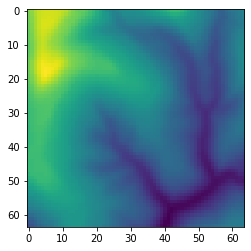

In [5]:
import matplotlib.pyplot as plt

dataset = ImagesDataset('./data')
plt.imshow(dataset[400].view(64, 64))
plt.show()

In [6]:
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

In [7]:
def double_cnn(in_n, out_n):
    return nn.Sequential(
        nn.Conv2d(in_n, out_n, 3, padding=1),       
        nn.ReLU(),        
        nn.Conv2d(out_n, out_n, 3, padding=1)
    )

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Encoder specification
        self.enc_cnn_1 = double_cnn(1, 32)
        self.enc_cnn_2 = double_cnn(32, 64)      
        self.enc_cnn_3 = double_cnn(64, 128)
        self.enc_cnn_4 = double_cnn(128, 256)
        
        self.enc_linear_1_1 = nn.Linear(4096, 64)
        self.enc_linear_1_2 = nn.Linear(4096, 64)
        
        # Decoder specification
        self.dec_linear_1 = nn.Linear(64, 4096)
        
        self.dec_cnn_1 = double_cnn(256, 128)
        self.dec_cnn_2 = double_cnn(128, 64)
        self.dec_cnn_3 = double_cnn(64, 32)
        self.dec_cnn_4 = double_cnn(32, 1)
        
    def encode(self, data):
        x = self.enc_cnn_1(data)
        x = F.relu(F.max_pool2d(x, 2))
        
        x = self.enc_cnn_2(x)
        x = F.relu(F.max_pool2d(x, 2))
        
        x = self.enc_cnn_3(x)
        x = F.relu(F.max_pool2d(x, 2))
        
        x = self.enc_cnn_4(x)
        x = F.relu(F.max_pool2d(x, 2))
        
        x = x.view(x.size(0), -1)
        return self.enc_linear_1_1(x), self.enc_linear_1_2(x)
    
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).cuda()
        return mu + std * esp
        
    def decode(self, code):
        out = F.relu(self.dec_linear_1(code))
        out = out.view(out.size(0), 256, 4, 4)
        
        out = F.interpolate(out, 8)
        out = F.relu(self.dec_cnn_1(out))
        
        out = F.interpolate(out, 16)
        out = F.relu(self.dec_cnn_2(out))
        
        out = F.interpolate(out, 32)
        out = F.relu(self.dec_cnn_3(out))
        
        out = F.interpolate(out, 64)
        out = torch.sigmoid(self.dec_cnn_4(out))
        return out
        
    def forward(self, data):
        mu, logvar = self.encode(data)
        code = self.reparametrize(mu, logvar)
        out = self.decode(code)
        return out, mu, logvar

In [8]:
vae = VAE().cuda()

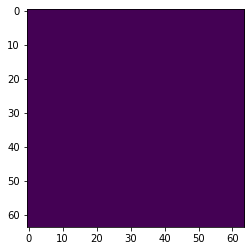

In [9]:
x = dataset[400].cuda()
out, _, _ = vae(x.view(1, 1, 64, 64))
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()

In [180]:
import torch.optim as optim

def loss_function(recon_x, x, mu, logvar):
    BCE = nn.MSELoss(reduction='sum')(recon_x, x)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

optimizer = optim.Adam(vae.parameters(), lr=0.001)

epochs = 100

for epoch in range(epochs):
    vae.train()
    for data in dataloader:
        optimizer.zero_grad()
        x = data.cuda()
        out, mu, logvar = vae(x)
        loss = loss_function(out, x, mu, logvar)
        loss.backward()
        optimizer.step()
    print('epoch=' + str(epoch + 1) + ', loss=' + str(loss))

epoch=1, loss=tensor(204.3071, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2, loss=tensor(101.6556, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3, loss=tensor(86.5924, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4, loss=tensor(39.2578, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5, loss=tensor(44.3239, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6, loss=tensor(61.5136, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7, loss=tensor(35.7183, device='cuda:0', grad_fn=<AddBackward0>)
epoch=8, loss=tensor(55.6938, device='cuda:0', grad_fn=<AddBackward0>)
epoch=9, loss=tensor(131.0282, device='cuda:0', grad_fn=<AddBackward0>)
epoch=10, loss=tensor(53.2788, device='cuda:0', grad_fn=<AddBackward0>)
epoch=11, loss=tensor(55.3861, device='cuda:0', grad_fn=<AddBackward0>)
epoch=12, loss=tensor(136.6671, device='cuda:0', grad_fn=<AddBackward0>)
epoch=13, loss=tensor(68.2166, device='cuda:0', grad_fn=<AddBackward0>)
epoch=14, loss=tensor(171.7714, device='cuda:0', grad_fn=<AddBackward

In [12]:
torch.cuda.empty_cache()

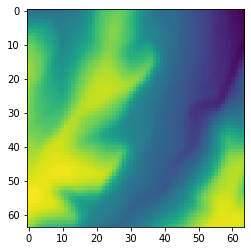

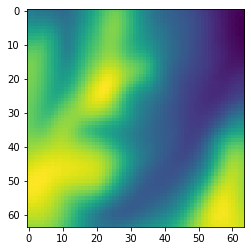

In [183]:
x = dataset[900].cuda()
plt.imshow(x.view(64, 64).cpu())
plt.show()
out, _, _ = vae(x.view(1, 1, 64, 64))
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()

In [186]:
#torch.save(vae.state_dict(), './variational_autoencoder_save')

In [10]:
vae.load_state_dict(torch.load('./variational_autoencoder_save'))

<All keys matched successfully>

In [190]:
import numpy as np

xs = []
for data in dataset:
    mu, logvar = vae.encode(data.cuda().view(1, 1, 64, 64))
    code = vae.reparametrize(mu, logvar)
    xs.append(code.cpu().detach()[0])

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [209]:
codes = torch.cat(xs).view(-1, 64)

In [212]:
codes[2]

tensor([ 0.3008, -0.4940,  0.7297,  1.0103,  0.4057,  1.2340,  0.2577,  1.1241,
        -0.0917,  0.3141,  0.1089,  0.0908,  0.2659, -0.8536, -0.9944, -0.2474,
        -0.0059, -0.2933,  0.3759,  0.9043,  0.3470,  1.3212,  0.4744,  0.5483,
        -0.3059, -0.7669,  0.6410,  0.1799,  0.0333,  0.3700,  0.2597,  0.2039,
         0.0562, -0.1416, -0.7374, -0.0052, -0.0398, -0.1495, -0.0627, -0.1182,
         0.3071, -0.2948,  0.1651,  0.4132,  0.3397, -0.7366,  0.1424, -0.2454,
        -0.7041, -0.0200, -0.1548, -0.5291,  0.5452, -0.3474,  0.0195, -0.7150,
         0.4013,  0.6835,  0.2653, -0.3120,  0.3496,  0.3146, -0.0826,  0.0161])

In [213]:
mean = codes.mean(axis=0)
std = codes.std(axis=0)

In [220]:
mean

tensor([ 5.3491e-02, -4.1797e-02,  2.0019e-01,  3.4256e-02,  4.6165e-02,
        -3.1788e+00,  1.6638e-01, -2.2471e+00, -2.1720e-03, -2.5511e-02,
         1.1032e-02,  4.9668e-03,  2.0659e-02, -9.2332e-03,  8.2505e-02,
        -1.6698e-02,  2.1964e-02, -1.7276e-01,  1.6489e-02,  4.4891e-02,
         6.6504e-02, -3.5978e-02,  6.9458e-03,  8.1555e-04, -4.1043e-02,
        -8.2029e-02,  2.4235e-02,  3.8675e-02, -1.0925e-02,  4.7908e-02,
         2.4383e-02, -8.1812e-02, -2.2655e-02,  1.1878e-02,  3.4206e-02,
         1.4996e-02,  1.5901e-02, -3.4655e-01, -1.6591e-03, -1.0020e-02,
        -4.7468e-02, -1.4901e-01,  3.0627e-02, -1.2700e-02,  8.1426e-02,
        -7.2822e-02,  6.3681e-04,  1.8814e-02,  6.5370e-02, -9.3683e-02,
        -4.3408e-02, -1.1025e-02, -1.2210e-02,  7.9937e-03, -3.1880e-02,
        -5.5523e-02, -5.0008e-02, -1.3038e-02, -1.4226e-02,  6.1845e-02,
         8.2444e-02, -9.6248e-03,  5.9602e-02,  4.5262e-02])

In [221]:
std

tensor([0.2984, 0.3506, 0.3693, 0.5137, 0.3491, 3.7725, 0.3711, 2.8414, 0.2529,
        0.2835, 0.2953, 0.2749, 0.4288, 0.6208, 0.3503, 0.2785, 0.2594, 0.2946,
        0.2585, 0.3094, 0.3196, 0.3663, 0.2912, 0.3272, 0.2912, 0.3430, 0.2954,
        0.2934, 0.2562, 0.2644, 0.2702, 0.4676, 0.3246, 0.5635, 0.2836, 0.2651,
        0.5265, 0.4200, 0.2670, 0.2896, 0.4032, 0.3346, 0.2620, 0.3604, 0.4404,
        0.4595, 0.3825, 0.2604, 0.3004, 0.3305, 0.2865, 0.3248, 0.3152, 0.3421,
        0.3024, 0.3334, 0.3733, 0.3538, 0.2586, 0.2957, 0.3297, 0.2595, 0.3100,
        0.3283])

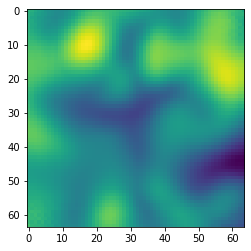

In [278]:
# Generator
code = torch.FloatTensor(1, 64).normal_()
code = mean + std * code

out = vae.decode(code.cuda())
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()